In [122]:
import pandas as pd

In [123]:
# Importamos los datos del btc desde 2022 a 2024, obtenidos de https://www.marketwatch.com/investing/cryptocurrency/btcusd/download-data

btc2024 = pd.read_csv("C:/Users/Bryan/Documents/Portafolio/BTC/btcusd2024.csv")
btc2023 = pd.read_csv("C:/Users/Bryan/Documents/Portafolio/BTC/btcusd2023.csv")
btc2022 = pd.read_csv("C:/Users/Bryan/Documents/Portafolio/BTC/btcusd2022.csv")

In [124]:
# Ordenamos los datos y eliminamos las columnas que no utilizaremos, además de darle formato a los dataframe.

df = pd.concat([btc2024, btc2023, btc2022])

df["date"] = pd.to_datetime(df["Date"], format="mixed")
df["usd"] = df["Close"]
df = df.drop(columns=["Date", "Open", "High", "Low", "Close"])
df = df.sort_values("date", ascending=False).reset_index(drop=True)

df["year"] = df["date"].dt.year.astype(int)
df["month"] = df["date"].dt.month_name()
df["day"] = df["date"].dt.day_name()

df["usd"] = df["usd"].str.replace(",", "").astype(float)
df_date = df.set_index("date").asfreq("D", method="ffill")

In [125]:
df

,date,usd,year,month,day
0,2024-05-03,62096.0,2024,May,Friday
1,2024-05-02,59336.0,2024,May,Thursday
2,2024-05-01,56979.0,2024,May,Wednesday
3,2024-04-30,59166.0,2024,April,Tuesday
4,2024-04-29,62955.0,2024,April,Monday
...,...,...,...,...,...
845,2022-01-07,41913.0,2022,January,Friday
846,2022-01-06,43207.0,2022,January,Thursday
847,2022-01-05,43944.0,2022,January,Wednesday
848,2022-01-04,46265.0,2022,January,Tuesday


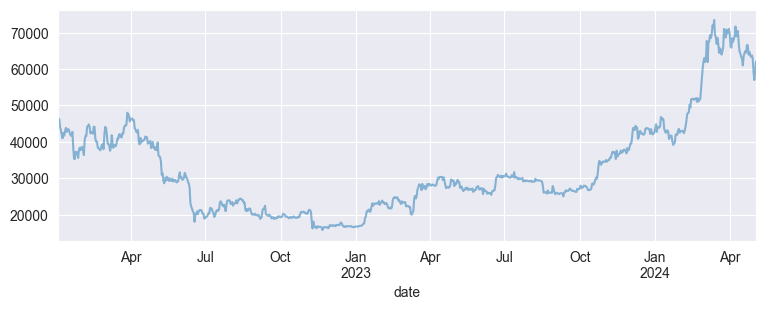

In [126]:
# Graficamos los valores antiguos y actuales del btc

import matplotlib.pyplot as plt

x = df_date.groupby("date").sum()["usd"]

plt.subplots(figsize=[9,3])
x.plot(alpha=0.5);

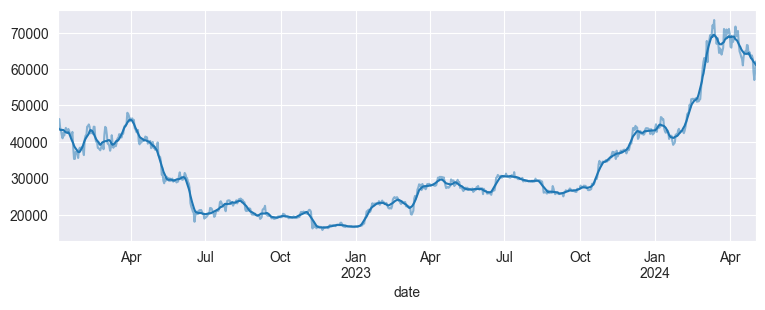

In [127]:
# Suavizamos los valores del btc a su promedio para observar la tendencia
# Se observa que actualmente el btc se encuentra en crecimiento, usaremos este ejemplo para hacer nuestra predicción

trend = x.rolling(window=12, center=True, min_periods=6).mean()

plt.subplots(figsize=[9,3])
x.plot(alpha=0.5)
trend.plot(color="C0");

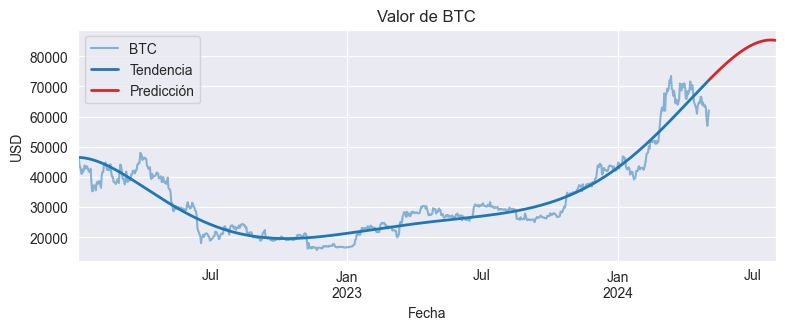

In [128]:
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

# Creamos una tendencia utilizando los datos y la función DeterministicProcess, el valor de order más adecuado encontramos que era 6, debido a que mantiene el patron de la tendencia anterior vista
# Procedemos a hacer una predicción a 90 días con la tendencia creada y a comparar los resultados
# Se puede observar que la tendencia sigue el patron del valor del BTC

dp = DeterministicProcess(index=x.index, order=6)

y = x.copy()
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

fig, ax = plt.subplots(figsize=[9,3])

y.plot(alpha=0.5, label="BTC")
y_pred.plot(ax=ax, linewidth=2, color="C0", label="Tendencia")
y_fore.plot(ax=ax, linewidth=2, color="C3", label="Predicción")
ax.set_title("Valor de BTC")
ax.set_ylabel("USD")
ax.set_xlabel("Fecha")
ax.legend();

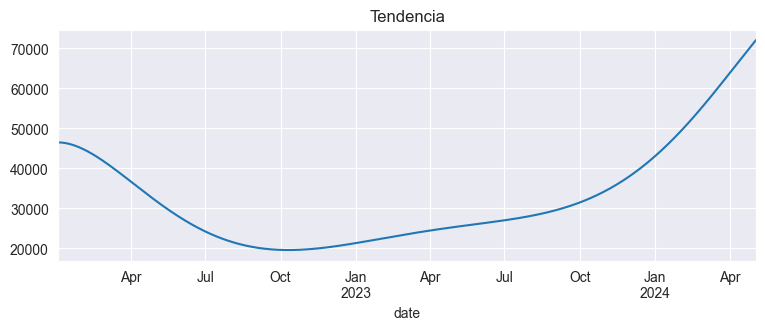

In [129]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Con la función seasonal_decompose, obtendremos los valores más próximos a la estacionalidad y los residuos de los datos, estos podremos utilizarlos para hacer las predicciones
# En este ejemplo, utilizaremos el modelo multiplicativo

dcx = seasonal_decompose(x, model="multiplicative", period=12)

ssx = dcx.seasonal
rdx = dcx.resid

plt.subplots(figsize=(9,3))
y_pred.plot(title="Tendencia");

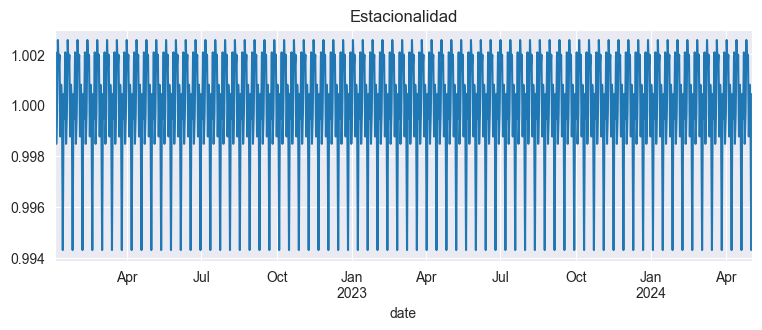

In [130]:
plt.subplots(figsize=(9,3))
ssx.plot(title="Estacionalidad");

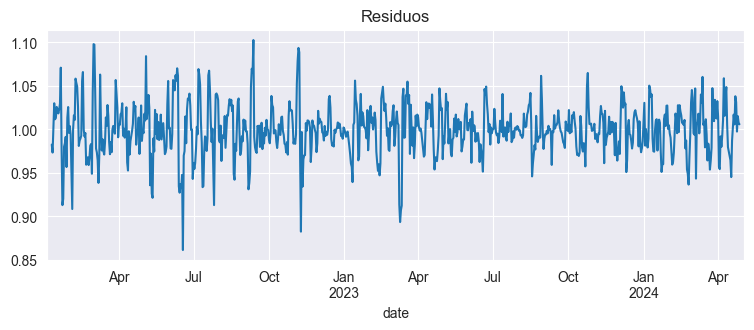

In [131]:
plt.subplots(figsize=(9,3))
rdx.plot(title="Residuos");

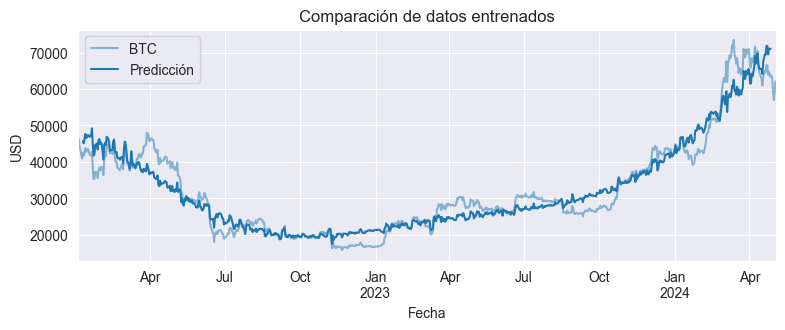

In [132]:
# Comparamos los datos entrenados por la máquina y los datos obtenidos, se puede observar que tienen una similitud

a = y_pred * ssx * rdx
fig, ax = plt.subplots(figsize=[9,3])
y.plot(alpha=0.5, label="BTC")
a.plot(label="Predicción", color="C0")
ax.set_title("Comparación de datos entrenados")
ax.set_ylabel("USD")
ax.set_xlabel("Fecha")
ax.legend();

In [134]:
# Creamos una predicción con los datos obtenidos de la estacionalidad a 90 días.

fc_ssx = ssx.copy()
fc_ssx = fc_ssx.index + pd.DateOffset(days=90)
fc_ssx = pd.DataFrame(fc_ssx)
fc_ssx["ssx"] = ssx.values
fc_ssx = fc_ssx.iloc[-90:]
fc_ssx = fc_ssx.set_index("date")
fc_ssx

,ssx
date,
2024-05-04,1.001981
2024-05-05,0.998770
2024-05-06,1.000801
2024-05-07,1.000022
2024-05-08,0.994313
...,...
2024-07-28,0.998770
2024-07-29,1.000801
2024-07-30,1.000022


In [135]:
# Creamos una predicción con los datos obtenidos de los residuos a 90 días.

fc_rdx = rdx.copy()
fc_rdx = fc_rdx.index + pd.DateOffset(days=90)
fc_rdx = pd.DataFrame(fc_rdx)
fc_rdx["rdx"] = rdx.values
fc_rdx = fc_rdx.iloc[-90:]
fc_rdx = fc_rdx.set_index("date")
fc_rdx

,rdx
date,
2024-05-04,0.975618
2024-05-05,0.959442
2024-05-06,0.962258
2024-05-07,0.973502
2024-05-08,0.996040
...,...
2024-07-28,NaN
2024-07-29,NaN
2024-07-30,NaN


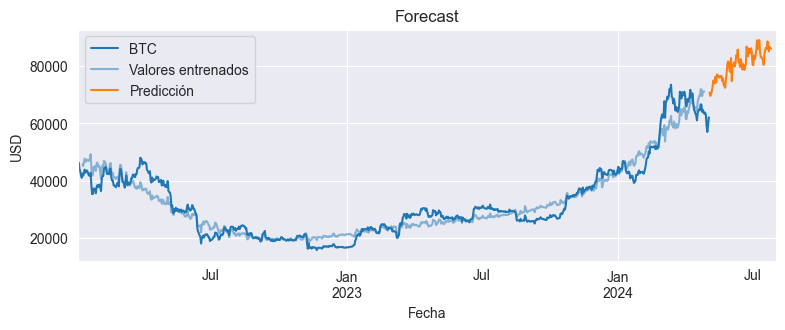

In [141]:
# Debido a que usamos un metodo multiplicativo, multiplicamos la tendencia, la estacionalidad y los residuos futuros para obtener la predicción a 90 días del BTC
# Este es el resultado final del estudio, como se puede observar, el BTC continuara creciendo en los siguientes 90 días
# Hay que entender que este es un forecast simple y hay probabilidades de que el BTC en vez de seguir aumentando, disminuya debido a factores externos que están fuera de nuestra predicción y estudio.

b = y_fore * fc_ssx["ssx"] * fc_rdx["rdx"]

fig, ax = plt.subplots(figsize=[9,3])
y.plot(color="C0", label="BTC")
a.plot(label="Valores entrenados", alpha=0.5)
b.plot(label="Predicción")
ax.set_title("Forecast")
ax.set_ylabel("USD")
ax.set_xlabel("Fecha")
ax.legend()
plt.savefig("graficos/btc_forecast.png");

In [137]:
# Compararemos nuestro resultado con una predicción hecha con auto_arima, en este caso dejaremos que auto_arima utilice sus valores predeterminados para hacer la predicción

from pmdarima.arima import auto_arima

model_auto = auto_arima(y, information_criterion="aic", trace=True)
model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14863.062, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=14704.411, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=14503.524, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=14505.208, Time=0.27 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.836 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  852
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -7249.762
Date:                Tue, 07 May 2024   AIC                          14503.524
Time:                        20:02:28   BIC                          14513.014
Sample:                    01-03-2022   HQIC                         14507.159
                         - 05-03-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9818      0.006   -168.840      0.000      -0.993      -0.970
sigma2      1.245e+06   2.59e+04     48.035      0.000    1.19e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                  15.11   Jarque-Bera (JB):              9220.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -1.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

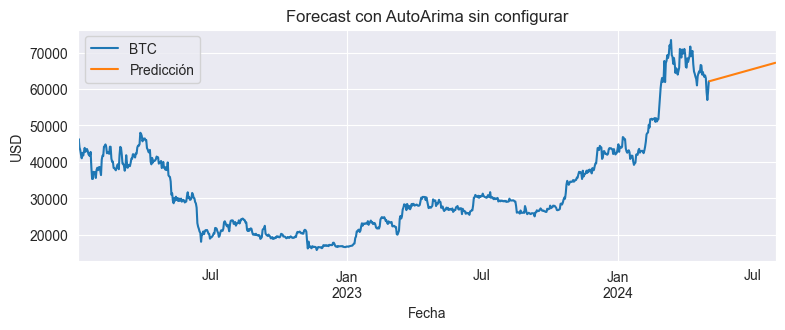

In [138]:
# Podemos notar un leve crecimiento, se representa en una recta debido a que nos faltan datos en nuestro estudio, variables externas que son complejas de predecir.

predict, confint = model_auto.predict(n_periods=90, return_conf_int=True)

fig, ax = plt.subplots(figsize=[9,3])
y.plot(label="BTC")
predict.plot(label="Predicción")
ax.set_title("Forecast con AutoArima sin configurar")
ax.set_ylabel("USD")
ax.set_xlabel("Fecha")
ax.legend();

In [139]:
# Ajustamos auto_arima para realizar una predicción más certera

model_auto = auto_arima(y, seasonal=True, max_p=8,max_d=8, max_q=8, information_criterion="aic", trace=True, m=12, d=1)
model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=14255.613, Time=2.05 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=14255.218, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=14258.102, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=14258.089, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=14253.499, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=14256.921, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=14256.939, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=14258.785, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=14256.405, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=14256.372, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=14258.075, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 3.197 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  852
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7125.749
Date:                Tue, 07 May 2024   AIC                          14253.499
Time:                        20:02:32   BIC                          14258.245
Sample:                    01-03-2022   HQIC                         14255.317
                         - 05-03-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.097e+06   2.81e+04     39.084      0.000    1.04e+06    1.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.96   Jarque-Bera (JB):               947.55
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.03
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

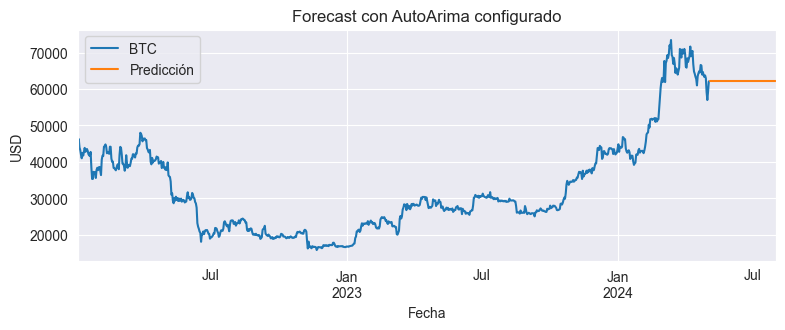

In [140]:
# Observamos que la predicción se mantiene en una recta estable

predict, confint = model_auto.predict(n_periods=90, return_conf_int=True)

fig, ax = plt.subplots(figsize=[9,3])
y.plot(label="BTC")
predict.plot(label="Predicción")
ax.set_title("Forecast con AutoArima configurado")
ax.set_ylabel("USD")
ax.set_xlabel("Fecha")
ax.legend();

In [140]:
# Según los datos historicos del BTC, y los estudios realizados, se concluye que este podría seguir en aumento o en un valor estable durante los próximos 90 días, recordar que esto solo es una posibilidad y que este estudio no contempla datos externos que podrían afectar su valor.